#Training & Evaluation Script

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

import os
import joblib
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import randint
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import shap
from lime.lime_tabular import LimeTabularExplainer

#Data Processing

In [ ]:
# Correcting the formatting issue by specifying the delimiter for the cardio_train dataset
cardio_data = pd.read_csv('/content/extracted_data/Cardiovascular Heart Disease/cardio_train.csv', delimiter=';')

# Display the corrected dataframe structure and initial statistics
cardio_corrected_head = cardio_data.head()
cardio_corrected_info = cardio_data.info()
cardio_corrected_describe = cardio_data.describe()

cardio_corrected_head, cardio_corrected_info, cardio_corrected_describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


(   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
 0   0  18393       2     168    62.0    110     80            1     1      0   
 1   1  20228       1     156    85.0    140     90            3     1      0   
 2   2  18857       1     165    64.0    130     70            3     1      0   
 3   3  17623       2     169    82.0    150    100            1     1      0   
 4   4  17474       1     156    56.0    100     60            1     1      0   
 
    alco  active  cardio  
 0     0       1       0  
 1     0       1       1  
 2     0       0       1  
 3     0       1       1  
 4     0       0       0  ,
 None,
                  id           age        gender        height        weight  \
 count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
 mean   49972.419900  19468.865814      1.349571    164.359229     74.205690   
 std    28851.302323   2467.251667      0.476838      8.210126     14.395757   
 min        0.000000  

#Class Distribution Analysis


cardio
0    35021
1    34979
Name: count, dtype: int64
Percentage of Minority Class: 49.97%
Gini Index: 0.50


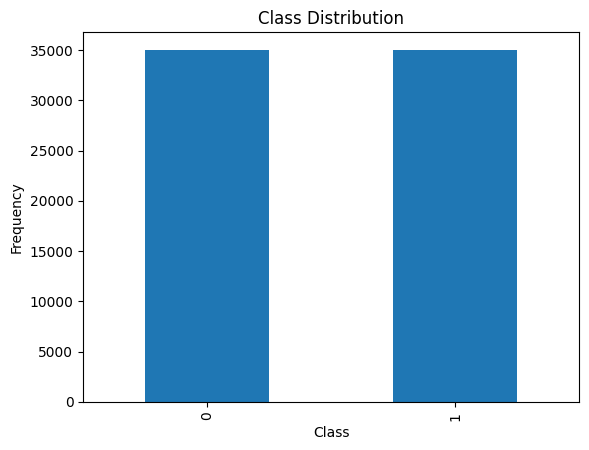

In [ ]:
# Extracting labels for easier access
labels = cardio_data['cardio']

# 'labels' is target Series in the dataset
class_distribution = labels.value_counts()
print(class_distribution)

# Calculate the percentage of the minority class
percentage_minority = class_distribution.min() / class_distribution.sum() * 100
print(f"Percentage of Minority Class: {percentage_minority:.2f}%")

# Gini index example for a binary classification
def gini_index(series):
    proportions = series.value_counts(normalize=True)
    squared_sum = np.sum(proportions**2)
    return 1 - squared_sum

gini = gini_index(labels)
print(f"Gini Index: {gini:.2f}")

# Plotting the class distribution
labels.value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

#Data Preparation and Cleaning

In [ ]:
# Convert age from days to years for easier interpretation
cardio_data['age_years'] = cardio_data['age'] / 365.25

# Addressing potential outliers and erroneous data
# Removing extreme or erroneous values for height, weight, and blood pressure

# Assuming human height should be between 100 cm and 250 cm
# Assuming weight should be more than 20 kg and less than 200 kg
# Assuming systolic blood pressure should be between 50 and 250 mmHg and diastolic between 30 and 180 mmHg
clean_cardio_data = cardio_data[
    (cardio_data['height'] >= 100) & (cardio_data['height'] <= 250) &
    (cardio_data['weight'] >= 20) & (cardio_data['weight'] <= 200) &
    (cardio_data['ap_hi'] >= 50) & (cardio_data['ap_hi'] <= 250) &
    (cardio_data['ap_lo'] >= 30) & (cardio_data['ap_lo'] <= 180)
]

# Summary of cleaned data
clean_cardio_info = clean_cardio_data.info()
clean_cardio_describe = clean_cardio_data.describe()

clean_cardio_info, clean_cardio_describe

<class 'pandas.core.frame.DataFrame'>
Index: 68751 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           68751 non-null  int64  
 1   age          68751 non-null  int64  
 2   gender       68751 non-null  int64  
 3   height       68751 non-null  int64  
 4   weight       68751 non-null  float64
 5   ap_hi        68751 non-null  int64  
 6   ap_lo        68751 non-null  int64  
 7   cholesterol  68751 non-null  int64  
 8   gluc         68751 non-null  int64  
 9   smoke        68751 non-null  int64  
 10  alco         68751 non-null  int64  
 11  active       68751 non-null  int64  
 12  cardio       68751 non-null  int64  
 13  age_years    68751 non-null  float64
dtypes: float64(2), int64(12)
memory usage: 7.9 MB


(None,
                  id           age        gender        height        weight  \
 count  68751.000000  68751.000000  68751.000000  68751.000000  68751.000000   
 mean   49971.717037  19464.569272      1.348737    164.396329     74.120477   
 std    28846.219470   2468.004772      0.476574      7.986628     14.312477   
 min        0.000000  10798.000000      1.000000    100.000000     21.000000   
 25%    24996.500000  17657.500000      1.000000    159.000000     65.000000   
 50%    50016.000000  19701.000000      1.000000    165.000000     72.000000   
 75%    74864.500000  21324.000000      2.000000    170.000000     82.000000   
 max    99999.000000  23713.000000      2.000000    250.000000    200.000000   
 
               ap_hi         ap_lo   cholesterol          gluc         smoke  \
 count  68751.000000  68751.000000  68751.000000  68751.000000  68751.000000   
 mean     126.614667     81.373231      1.364795      1.226033      0.087999   
 std       16.761329      9.662

#Feature Selection & Data Scaling

In [ ]:
# Feature selection for modeling
features = clean_cardio_data.drop(columns=['id', 'cardio', 'age'])
labels = clean_cardio_data['cardio']

# Data Scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

poly = PolynomialFeatures(degree=2, include_bias=False)
features_poly = poly.fit_transform(features_scaled)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_poly, labels, test_size=0.2, random_state=42)

# Output the shapes of the training and test data sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(55000, 90) (13751, 90) (55000,) (13751,)


Best parameters selected by grid search:  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Average cross-validation score: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      6980
           1       0.74      0.69      0.71      6771

    accuracy                           0.73     13751
   macro avg       0.73      0.73      0.73     13751
weighted avg       0.73      0.73      0.73     13751

F-1 Score: 0.7135970617491775
Precision: 0.7403937758018418
Recall: 0.6886722788362133
ROC AUC Score: 0.7916516015757409


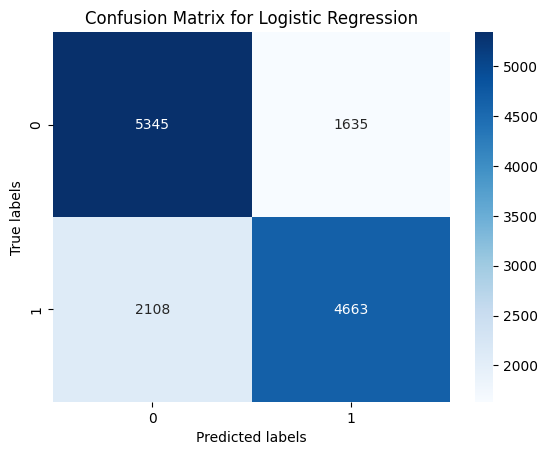

['lr_model.pkl']

In [ ]:
# Feature Selection using Recursive Feature Elimination
selector = RFE(LogisticRegression(solver='liblinear', max_iter=500), n_features_to_select=5, step=1)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Hyperparameter Tuning with Cross-Validation using GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 5], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_search = GridSearchCV(LogisticRegression(max_iter=500), param_grid, cv=5, scoring = 'roc_auc')
grid_search.fit(X_train_selected, y_train)

# Output the grid search range and the best parameters
print("Best parameters selected by grid search: ", grid_search.best_params_)

# Best model obtained from grid search
best_lr = grid_search.best_estimator_

# Cross-validation to evaluate model
scores = cross_val_score(best_lr, X_train_selected, y_train, cv=5)
print("Average cross-validation score: {:.2f}".format(scores.mean()))

# Final Model Evaluation on Test Data
y_pred = best_lr.predict(X_test_selected)
y_prob = best_lr.predict_proba(X_test_selected)[:, 1]  # Probability estimates for ROC AUC

# Performance metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Calculate overall F-1 score, precision, and recall
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("F-1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Save the model to disk
joblib.dump(best_lr, 'lr_model.pkl')

Best parameters selected by grid search:  {'n_neighbors': 20}
Average cross-validation score: 0.72
Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.70      0.79      0.74      6980
           1       0.75      0.65      0.70      6771

    accuracy                           0.72     13751
   macro avg       0.73      0.72      0.72     13751
weighted avg       0.73      0.72      0.72     13751

F-1 Score for KNN: 0.6988958990536278
Precision for KNN: 0.7498730749703841
Recall for KNN: 0.6544085068675233
ROC AUC Score for KNN: 0.7839026964396874


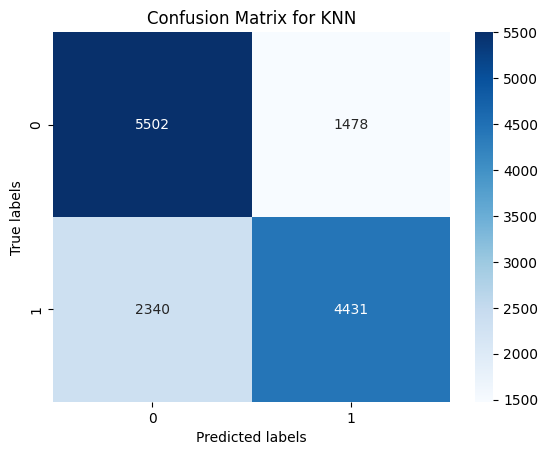

In [ ]:
# Define the KNN model and hyperparameters for grid search
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(1, 21))}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Output the grid search range and the best parameters
print("Best parameters selected by grid search: ", grid_search.best_params_)

# Find the best model
best_knn = grid_search.best_estimator_

# Cross-validation to evaluate model
scores = cross_val_score(best_knn, X_train, y_train, cv=5)
print("Average cross-validation score: {:.2f}".format(scores.mean()))

# Final Model Evaluation on Test Data
y_pred_knn = best_knn.predict(X_test)
y_prob_knn = best_knn.predict_proba(X_test)[:, 1]  # Probability estimates for ROC AUC

# Performance metrics
print("Classification Report for KNN:")
print(classification_report(y_test, y_pred_knn))
# Calculate overall F-1 score, precision, and recall for KNN
f1_knn = f1_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)

print("F-1 Score for KNN:", f1_knn)
print("Precision for KNN:", precision_knn)
print("Recall for KNN:", recall_knn)
print("ROC AUC Score for KNN:", roc_auc_score(y_test, y_prob_knn))

# Confusion matrix for KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for KNN')
plt.show()

# Save the model to disk
joblib.dump(best_knn, 'knn_model.pkl')

Best parameters selected by grid search:  {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.7}
Average cross-validation score: 0.73
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6980
           1       0.75      0.69      0.72      6771

    accuracy                           0.74     13751
   macro avg       0.74      0.74      0.74     13751
weighted avg       0.74      0.74      0.74     13751

F-1 Score: 0.7203696572968811
Precision: 0.7526552944962986
Recall: 0.6907399202481169
ROC AUC Score: 0.8027795410140752


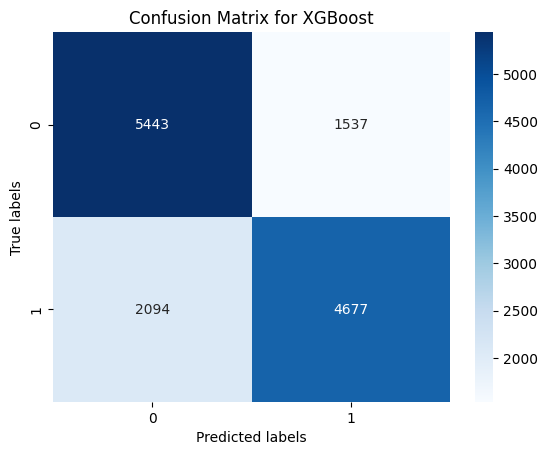

['xgb_model.pkl']

In [ ]:

# Define XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
)

# Hyperparameter Tuning with Cross-Validation using GridSearchCV
param_grid = {
    'max_depth': [4, 5, 6],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 150, 200],
    'colsample_bytree': [0.4, 0.5, 0.6],
    'subsample': [0.5, 0.6, 0.7],
    'gamma': [0, 0.05, 0.1]
}
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Output the grid search range and the best parameters
print("Best parameters selected by grid search: ", grid_search.best_params_)

# Best model obtained from grid search
best_xgb = grid_search.best_estimator_

# Cross-validation to evaluate model
scores = cross_val_score(best_xgb, X_train, y_train, cv=5)
print("Average cross-validation score: {:.2f}".format(scores.mean()))

# Final Model Evaluation on Test Data
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]  # Probability estimates for ROC AUC

# Performance metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Calculate overall F-1 score, precision, and recall
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("F-1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for XGBoost')
plt.show()


# Save the model to disk
joblib.dump(best_xgb, 'xgb_model.pkl')

In [ ]:
# Define Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Hyperparameter Tuning with Cross-Validation using RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(200, 600),
    'max_depth': randint(10, 40),
    'min_samples_split': randint(2, 4),
    'min_samples_leaf': randint(1, 3),
    'bootstrap': [True]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_distributions,
                                   n_iter=50, cv=5, scoring='roc_auc', verbose=1, n_jobs=4,
                                   random_state=42)
random_search.fit(X_train, y_train)

# Output the best parameters found by random search
print("Best parameters found by random search: ", random_search.best_params_)

# Best model obtained from random search
best_rf = random_search.best_estimator_

# Cross-validation to evaluate model
scores = cross_val_score(best_rf, X_train, y_train, cv=5)
print("Average cross-validation score: {:.2f}".format(scores.mean()))

# Final Model Evaluation on Test Data
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]  # Probability estimates for ROC AUC

# Performance metrics
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred))
# Calculate overall F-1 score, precision, and recall
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("F-1 Score for Random Forest:", f1)
print("Precision for Random Forest:", precision)
print("Recall for Random Forest:", recall)
print("ROC AUC Score for Random Forest:", roc_auc)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

# Save the best model
joblib.dump(best_rf, 'best_random_forest_model.pkl')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
# Define SVM classifier with initial parameters
svm_clf = SVC(kernel='linear', probability=True, random_state=42)

# Hyperparameter tuning setup using RandomizedSearchCV for efficiency
param_distributions = {
    'C': [8, 10, 15, 30, 60]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    svm_clf,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

# Output the best parameters found by random search
print("Best parameters found: ", random_search.best_params_)

# Best model obtained from random search
best_svm = random_search.best_estimator_

# Model Evaluation on the test data
y_pred = best_svm.predict(X_test)
y_prob = best_svm.predict_proba(X_test)[:, 1]  # Probability estimates for ROC AUC

# Performance metrics
print("Classification Report for SVM:")
print(classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score for SVM:", roc_auc)

# Calculate overall F-1 score, precision, and recall
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("F-1 Score for SVM:", f1)
print("Precision for SVM:", precision)
print("Recall for SVM:", recall)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for SVM')
plt.show()

joblib.dump(best_svm, 'best_svm_model.pkl')

In [ ]:


# Initialize the Decision Tree Classifier
dtree = DecisionTreeClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Setup GridSearchCV
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Best model obtained from GridSearch
best_dtree = grid_search.best_estimator_

# Predict on the test data
y_pred = best_dtree.predict(X_test)
y_prob = best_dtree.predict_proba(X_test)[:, 1]  # Predict probabilities for ROC AUC

# Performance metrics
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score for Decision Tree:", roc_auc)

# Calculate overall F-1 score, precision, and recall
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("F-1 Score for Decision Tree:", f1)
print("Precision for Decision Tree:", precision)
print("Recall for Decision Tree:", recall)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

# Save the entire grid search object
joblib.dump(grid_search, 'best_dtree_model.pkl')

In [ ]:


# Initialize the Gradient Boosting Classifier
gbm = GradientBoostingClassifier(random_state=42)

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5],
    'max_depth': [3, 5, 8, 10, 15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10, 20, 30],
    'min_samples_leaf': [1, 3, 5, 10, 20]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    gbm,
    param_distributions,
    n_iter=20,  # You can adjust the number of iterations
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

# Output the best parameters found by RandomizedSearchCV
print("Best parameters found: ", random_search.best_params_)

# Best model obtained from RandomizedSearch
best_gbm = random_search.best_estimator_

# Predict on the test data
y_pred = best_gbm.predict(X_test)
y_prob = best_gbm.predict_proba(X_test)[:, 1]  # Predict probabilities for ROC AUC

# Evaluate the model
print("Classification Report for GBM:")
print(classification_report(y_test, y_pred))

# Calculate ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score for GBM:", roc_auc)

# Calculate overall F-1 score, precision, and recall
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("F-1 Score for GBM:", f1)
print("Precision for GBM:", precision)
print("Recall for GBM:", recall)

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for GBM')
plt.show()

# Save the best model
joblib.dump(best_gbm, 'best_gbm_model.pkl')

In [ ]:
pip install lime

In [ ]:


# Load your XGBoost model
model = joblib.load('/content/xgb_model.pkl')

features = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

# Convert X_train and X_test to DataFrames if they are not already
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=features)
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=features)

# Initialize the LIME Explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,  # Convert DataFrame to numpy array for LIME
    feature_names=features,
    class_names=['Negative', 'Positive'],
    mode='classification'
)

# Choose an instance to explain
i = 10  # Index of the instance in the dataset
exp = explainer.explain_instance(
    data_row=X_test.iloc[i].astype(float),
    predict_fn=model.predict_proba,  # Use predict_proba method of your model
    num_features=5
)

# Display the explanation
exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
# Assuming you know the feature names
feature_names = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio' ]

# Convert numpy array to DataFrame with these names
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Now you can check the columns
print(X_test_df.columns)

In [ ]:
# Load your XGBoost model
model = joblib.load('/content/xgb_model.pkl')

# Example feature names, ensure these match exactly with your model's features
feature_names = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

# Convert numpy array to DataFrame with these names
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Initialize the SHAP Explainer with your model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_df)

# Summarize the effects of all the features using the DataFrame
shap.summary_plot(shap_values, X_test_df, plot_type="bar")

# SHAP summary plot to show the SHAP values of every feature for every sample
shap.summary_plot(shap_values, X_test_df)

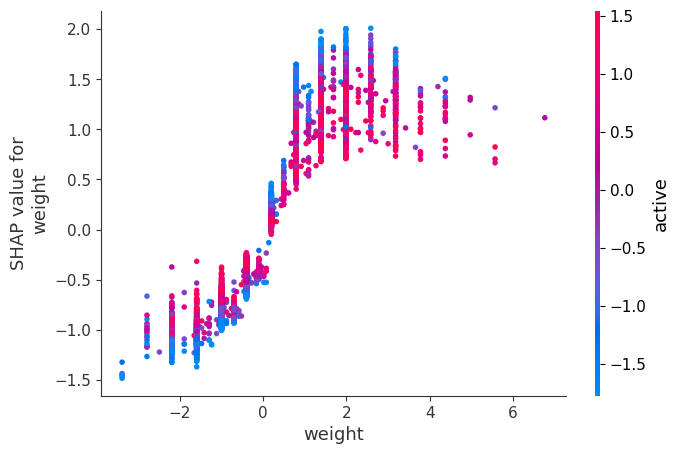

In [ ]:
# Load your model
model = joblib.load('/content/xgb_model.pkl')

# Assume X_test is loaded and properly formatted as a DataFrame
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plotting the dependence plot for 'feature1', automatically selecting interaction
shap.dependence_plot('weight', shap_values, X_test, interaction_index='auto')